2Bilayer unit domain. Sigma optimisation. Erro eig+eigv.

In [363]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


Domain, PML, refinement and physical configurations

In [364]:
sigma_sweep_quadratic=np.linspace(40,300, 21) #61


In [365]:
# Define element size for the mesh refinement
# h_i = [0.125,
#     0.0625,
#     0.0625 / 2,
#     0.0625 / 4,
#     0.0625 / 8]
h=0.0625/4

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 1.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 2.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4
sigma_0 = 1 #0.484375

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [366]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh, subdomain_data=[(1, fluid_cells)])

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-7, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-2.5j)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [367]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof, exact_value):
    from numpy import abs

    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real maior que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    if not (0 <= selected_index < len(eigenvalues)):
        raise IndexError("selected_index fóra de rango dos eigenvalores filtrados")

    # Comprobación do máis próximo ao exacto nun rango de ±5
    i_min = max(0, selected_index - 5)
    i_max = min(len(eigenvalues), selected_index + 6)

    closest_idx = min(
        range(i_min, i_max),
        key=lambda i: abs(eigenvalues[i][0] - exact_value)
    )

    if closest_idx != selected_index:
        print(f"Aviso: o índice {selected_index} non é o máis próximo ao valor exacto.")
        print(f"O máis próximo é o índice {closest_idx} con valor {eigenvalues[closest_idx][0]}")
    # else:
        # print("O índice seleccionado é o máis próximo ao valor exacto.")

    # Seleccionar o autovalor e vector correspondente
    omega_value, vrA = eigenvalues[closest_idx]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] /= p_h.eval([Lx, 0.0, 0.0], 1)  # normalizar
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] /= v_h.eval([Lx, 0.0, 0.0], 1)  # normalizar

    return [omega_value, p_h, v_h]


In [368]:
x_hat_quadratic=lambda x, w: (
            x[0]
            + (np.abs(x[0]) > Lx)
            * np.sign(x[0])
            * 1j
            / w
            * sigma_0
            * (np.abs(x[0]) - Lx) ** 3
            / (3 * pml_thickness**2)
        )

In [369]:
gamma_x_quadratic= lambda x, omega: 1.0 + (np.abs(x[0]) >= Lx) * 1j / omega * sigma_0 * (np.abs(x[0]) - Lx) ** 2

In [370]:
def get_exact_eigenpair(solver, selected_index, Q, V, sigma_i=0.):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)
    x_hat=x_hat_quadratic
    gamma_x= gamma_x_quadratic
    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))

    sigma_x = lambda x: np.where(x[0] >= Lx, x[0]*0.0) #sigma_i * (np.abs(x[0]) - Lx) ** 3, 0)
    # sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x(x)))
    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, sigma_x(x), sigma_x(x)))

    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    # v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

quadratic

In [371]:

# Initialize lists to store the approximated eigenpairs
approx_quadratic_P1_P0 = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_quadratic))]
approx_quadratic_P2_P1 = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_quadratic))]
approx_quadratic_P3_P2 = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_quadratic))]
approx_quadratic_P4_P3 = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_quadratic))]

for i,sigma_i in enumerate(sigma_sweep_quadratic):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    #Redefines sigma for quadratic profile depending on sigma_i value
    # Define quadratic sigma function
    sigma_x_quadratic=lambda x: conditional(x[0] > Lx, sigma_i*(x[0]-Lx)**2, 0.0)
    # Define solver for quadratic PML
    [solver_quadratic_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_x_quadratic)
    [solver_quadratic_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_x_quadratic)
    [solver_quadratic_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_quadratic)
    [solver_quadratic_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_x_quadratic)


    # Get the exact eigenpair for the current sigma_i
    exact = []
    for n in range(5):
        w, _, _ = get_exact_eigenpair(solver_quadratic_P1_P0, n, Q_P1_P0, V_P1_P0)
        exact.append(w)
    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_quadratic_P1_P0[i][j] = get_approx_eigenpair(solver_quadratic_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0, exact[j])[0]
        approx_quadratic_P2_P1[i][j] = get_approx_eigenpair(solver_quadratic_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1, exact[j])[0]
        approx_quadratic_P3_P2[i][j] = get_approx_eigenpair(solver_quadratic_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2, exact[j])[0]
        approx_quadratic_P4_P3[i][j] = get_approx_eigenpair(solver_quadratic_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3, exact[j])[0]

# Ordenar cada fila de la lista
for i in range(len(approx_quadratic_P1_P0)):
    approx_quadratic_P1_P0[i] = sorted(approx_quadratic_P1_P0[i], key=lambda x: x.real)
    approx_quadratic_P2_P1[i] = sorted(approx_quadratic_P2_P1[i], key=lambda x: x.real)
    approx_quadratic_P3_P2[i] = sorted(approx_quadratic_P3_P2[i], key=lambda x: x.real)
    approx_quadratic_P4_P3[i] = sorted(approx_quadratic_P4_P3[i], key=lambda x: x.real)


ValueError: either both or neither of x and y should be given

In [ ]:
exact = []
exact_p=[]
exact_v = []
# Get the exact eigenpairs for the first 5 eigenvalues
for n in range(5):
    w, p, v = get_exact_eigenpair(solver_quadratic_P1_P0, n, Q_P1_P0, V_P1_P0)
    exact.append(w)
    exact_p.append(p)
    exact_v.append(v)

In [ ]:
def group_by_real_part(eigenvalues, tolerance=1):
    groups = []
    for row in eigenvalues:
        for eig in row:
            added = False
            for group in groups:
                if abs(group[0].real - eig.real) < tolerance:
                    group.append(eig)
                    added = True
                    break
            if not added:
                groups.append([eig])
    return groups

groups_P1_P0 = group_by_real_part(approx_quadratic_P1_P0)
groups_P2_P1 = group_by_real_part(approx_quadratic_P2_P1)
groups_P3_P2 = group_by_real_part(approx_quadratic_P3_P2)
groups_P4_P3 = group_by_real_part(approx_quadratic_P4_P3)

In [ ]:
# Calculate relative error for each eigenvalue
rel_error_eig_0_P1_P0=abs((groups_P1_P0[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P1_P0=abs((groups_P1_P0[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P1_P0=abs((groups_P1_P0[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P1_P0=abs((groups_P1_P0[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P2_P1=abs((groups_P2_P1[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P2_P1=abs((groups_P2_P1[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P2_P1=abs((groups_P2_P1[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P2_P1=abs((groups_P2_P1[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P3_P2=abs((groups_P3_P2[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P3_P2=abs((groups_P3_P2[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P3_P2=abs((groups_P3_P2[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P3_P2=abs((groups_P3_P2[3] - exact[3])) / np.abs(exact[3]) 

rel_error_eig_0_P4_P2=abs((groups_P4_P3[0] - exact[0])) / np.abs(exact[0]) 
rel_error_eig_1_P4_P2=abs((groups_P4_P3[1] - exact[1])) / np.abs(exact[1]) 
rel_error_eig_2_P4_P2=abs((groups_P4_P3[2] - exact[2])) / np.abs(exact[2]) 
rel_error_eig_3_P4_P2=abs((groups_P4_P3[3] - exact[3])) / np.abs(exact[3]) 

In [ ]:
# Xa veñen os dous autovectores normalizados
p_approx=get_approx_eigenpair(solver_quadratic_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0, exact[1])[1]
np.linalg.norm(p_approx.x.petsc_vec.array[:] - exact_p[1].x.petsc_vec.array[:]) / n

np.linalg.norm(exact_p[1].x.petsc_vec.array[:])

Aviso: o índice 4 non é o máis próximo ao valor exacto.
O máis próximo é o índice 2 con valor (10.231381248078172-0.7803583651764205j)


np.float64(1.1659280826783105)

In [ ]:
len(exact_p[0].x.petsc_vec.array[:]), len(p_approx.x.petsc_vec.array[:])

(81, 81)

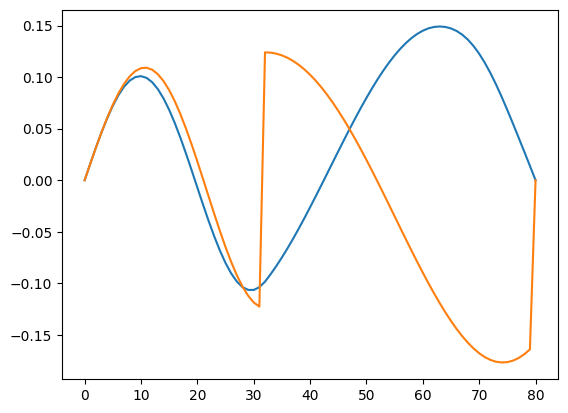

In [ ]:
plt.plot(p_approx.x.petsc_vec.array[:])
plt.plot(exact_p[1].x.petsc_vec.array[:])

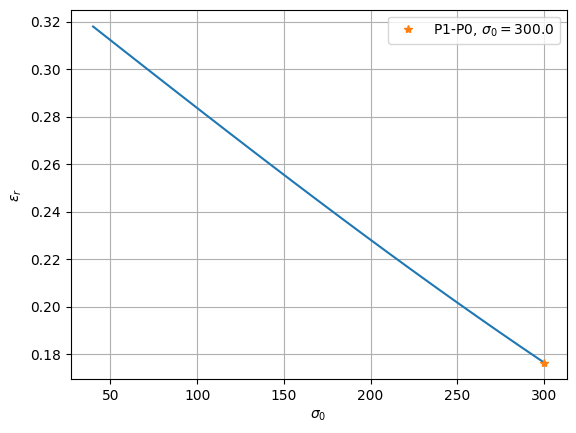

In [ ]:
plt.plot(sigma_sweep_quadratic,rel_error_eig_0_P1_P0)
plt.plot(sigma_sweep_quadratic[np.argmin(rel_error_eig_0_P1_P0)], rel_error_eig_0_P1_P0[np.argmin(rel_error_eig_0_P1_P0)], '*', label='P1-P0, $\sigma_0='+str(sigma_sweep_quadratic[np.argmin(rel_error_eig_0_P1_P0)])+'$')
# plt.plot(sigma_sweep_quadratic,rel_error_eig_0_P2_P1)
# plt.plot(sigma_sweep_quadratic[np.argmin(rel_error_eig_0_P2_P1)], rel_error_eig_0_P2_P1[np.argmin(rel_error_eig_0_P2_P1)], '*', label='P2-P1, $\sigma_0='+str(sigma_sweep_quadratic[np.argmin(rel_error_eig_0_P2_P1)])+'$')

plt.xlabel('$\sigma_0$')
plt.ylabel('$\epsilon_r$')
plt.grid(True)
_=plt.legend()